# Differentiating weed from crop seedlings
Further info [here](https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset)

In [1]:
!python -V

Python 3.8.19


In [2]:
# general imports
import os
from pathlib import Path
import sys
import random
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# DL
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, InputLayer
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf

pd.set_option("display.max_columns", None)

In [3]:
print("keras version: ", keras.__version__)
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

keras version:  2.9.0


In [4]:
# import s3 class to read images
sys.path.append('..')
from utils.s3_class import S3Functions

In [5]:
# set seeds
SEED = 202407
os.environ['PYTHONHASHSEED'] = SEED
random.seed(SEED)
np.random.seed(SEED)
tf.set_random_seed(SEED)
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.Session(
    grahp=tf.get_default_graph(),
    config=session_conf,
)
K.set_session(sess)

In [ ]:
s3_funcs = S3Functions(bucket_name='jdgallegoq-mlops')

## Load images

In [6]:
DATA_FOLDER = "v2-plant-seedlings-dataset"
train = pd.read_csv(
    s3_funcs.read_object(key=os.path.join(DATA_FOLDER, 'train.csv'))
).rename(columns={'Unnamed: 0': 'index'})
test = pd.read_csv(
    s3_funcs.read_object(key=os.path.join(DATA_FOLDER, 'test.csv'))
).rename(columns={'Unnamed: 0': 'index'})

In [7]:
# check percentages of images per clas in train and test
train['target'].value_counts(normalize=True), test['target'].value_counts(normalize=True)

(target
 Loose Silky-bent             0.136538
 Common Chickweed             0.127059
 Scentless Mayweed            0.109456
 Small-flowered Cranesbill    0.105845
 Fat Hen                      0.095689
 Sugar beet                   0.084180
 Charlock                     0.080794
 Cleavers                     0.062288
 Black-grass                  0.055067
 Shepherds Purse              0.049199
 Maize                        0.048747
 Common wheat                 0.045137
 Name: proportion, dtype: float64,
 target
 Loose Silky-bent             0.141697
 Common Chickweed             0.135379
 Scentless Mayweed            0.110108
 Fat Hen                      0.102888
 Small-flowered Cranesbill    0.096570
 Charlock                     0.084838
 Sugar beet                   0.081227
 Black-grass                  0.058664
 Cleavers                     0.053249
 Shepherds Purse              0.050542
 Common wheat                 0.047834
 Maize                        0.037004
 Name: propor

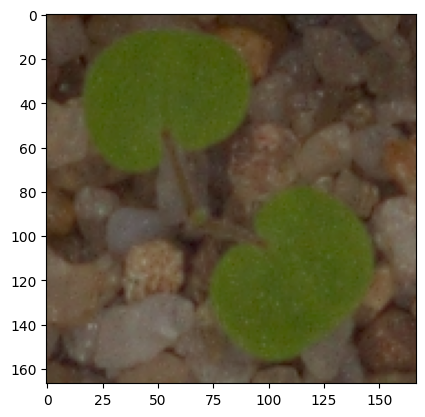

In [8]:
# plot a sample image
img = s3_funcs.read_image(key=train.image[0], asarray=False)
plt.imshow(img)

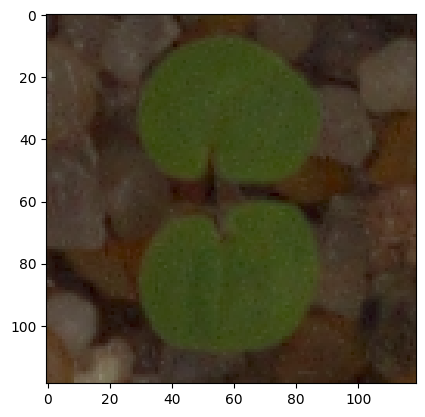

In [9]:
img = s3_funcs.read_image(key=train.image[47], asarray=False)
plt.imshow(img)

## Prepare data

In [10]:
X_train = train['image']
y_train = train['target']
X_test = test['image']
y_test = test['target']

encoder = LabelEncoder()
encoder.fit(y_train)
train_y = to_categorical(encoder.transform(y_train))
test_y = to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [11]:
y_train.value_counts(normalize=True)

target
Loose Silky-bent             0.136538
Common Chickweed             0.127059
Scentless Mayweed            0.109456
Small-flowered Cranesbill    0.105845
Fat Hen                      0.095689
Sugar beet                   0.084180
Charlock                     0.080794
Cleavers                     0.062288
Black-grass                  0.055067
Shepherds Purse              0.049199
Maize                        0.048747
Common wheat                 0.045137
Name: proportion, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

target
Loose Silky-bent             0.141697
Common Chickweed             0.135379
Scentless Mayweed            0.110108
Fat Hen                      0.102888
Small-flowered Cranesbill    0.096570
Charlock                     0.084838
Sugar beet                   0.081227
Black-grass                  0.058664
Cleavers                     0.053249
Shepherds Purse              0.050542
Common wheat                 0.047834
Maize                        0.037004
Name: proportion, dtype: float64

In [13]:
# images should be reshaped
IMAGE_SIZE = 150

def create_dataset(df, image_size):
    tmp = np.zeros((len(df), image_size, image_size, 3), dtype='float32')
    for n in range(0, len(df)):
        img = resize(
            image=s3_funcs.read_image(
            key=df[n]
            ),
            output_shape=(image_size, image_size)
        )
        tmp[n] = img
        
        print("dataset images shape: {} size: {:,}".format(tmp.shape, tmp.size))
        return tmp

In [14]:
x_train = create_dataset(X_train, IMAGE_SIZE)

dataset images shape: (4431, 150, 150, 3) size: 299,092,500


In [15]:
x_test = create_dataset(X_test, IMAGE_SIZE)

dataset images shape: (1108, 150, 150, 3) size: 74,790,000


## Model arquitecture

In [16]:
# following course material
kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

first_dense_units = 178
output_dense_units = len(y_train.unique()) # 12 are the target label numbers

In [17]:
model = Sequential()
model.add(InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout_conv))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(first_dense_units, activation='relu'))
model.add(Dropout(dropout_dense))
model.add(Dense(output_dense_units, activation='softmax'))

model.summary()

2024-07-17 20:48:21.359454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-17 20:48:21.411412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-17 20:48:21.411808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-17 20:48:21.413619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                        

`cutoff half parameters to train due to resources. (original guideline has 256 units on first Dense)`

## Compile and train

In [18]:
model.compile(
    Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [19]:
# define batch size and epochs for training
batch_size = 128
epochs = 10

filepath = "./module/models/model.h5"
# checkpoint by accuracy
checkpoint = ModelCheckpoint(
    filepath,
    monitor='accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)
# reduces learning rate when a metric stop improving
reduce_lr = ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='max',
    min_lr=1e-5
)

# define callbacks
callbacks_list = [checkpoint, reduce_lr]

# train
history = model.fit(
    x=x_train,
    y=train_y,
    batch_size=batch_size,
    validation_split=0.1,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks_list
)

Epoch 1/10


2024-07-17 20:48:25.994678: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500



Epoch 1: accuracy improved from -inf to 0.09932, saving model to ./module/models/model.h5
32/32 - 13s - loss: 0.6890 - accuracy: 0.0993 - val_loss: 0.6582 - val_accuracy: 0.1351 - lr: 1.0000e-04 - 13s/epoch - 413ms/step
Epoch 2/10

Epoch 2: accuracy improved from 0.09932 to 0.10735, saving model to ./module/models/model.h5
32/32 - 7s - loss: 0.5000 - accuracy: 0.1073 - val_loss: 0.3105 - val_accuracy: 0.1351 - lr: 1.0000e-04 - 7s/epoch - 230ms/step
Epoch 3/10

Epoch 3: accuracy did not improve from 0.10735

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
32/32 - 7s - loss: 0.3050 - accuracy: 0.1061 - val_loss: 0.2827 - val_accuracy: 0.1351 - lr: 1.0000e-04 - 7s/epoch - 219ms/step
Epoch 4/10

Epoch 4: accuracy improved from 0.10735 to 0.11287, saving model to ./module/models/model.h5
32/32 - 7s - loss: 0.2980 - accuracy: 0.1129 - val_loss: 0.2815 - val_accuracy: 0.1351 - lr: 5.0000e-05 - 7s/epoch - 231ms/step
Epoch 5/10

Epoch 5: accuracy did not improve fro

## Evaluate

<Figure size 640x480 with 0 Axes>

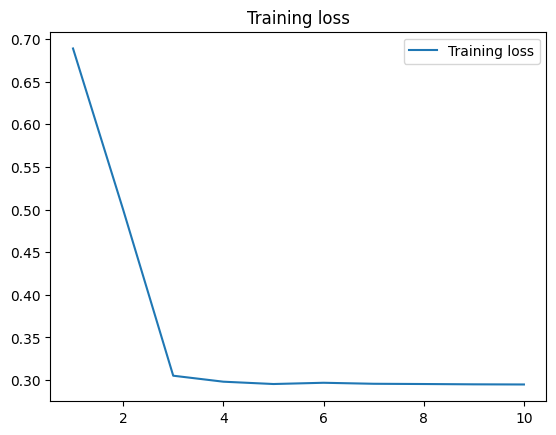

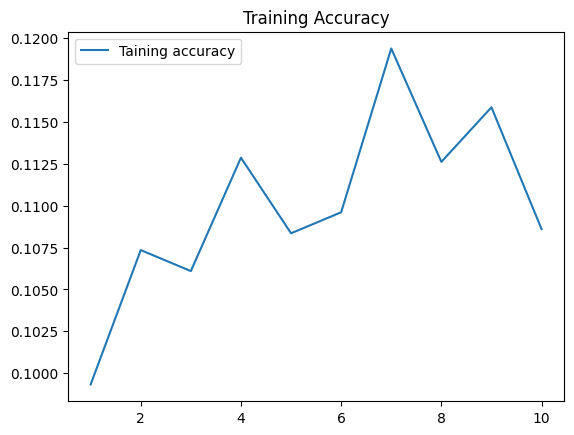

<Figure size 640x480 with 0 Axes>

In [20]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc)+1)

# plot loss
plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()
# plot accuracy
plt.plot(epochs, acc, label='Taining accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.figure()

In [21]:
# get predictions
preds = np.argmax(model.predict(x_test, verbose=1), axis=-1)
print(preds)
# transform target
print(encoder.transform(y_test))

35/35 [==============================] - 1s 20ms/step
[10  6  6 ...  6  6  6]
[3 2 9 ... 3 2 8]


In [22]:
# explore metrics
conf_matrix = confusion_matrix(
    encoder.transform(y_test),
    preds
)

# create a dict to map back numbers onto classes
tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis=1)
tmp.columns = ['class_name', 'class_number']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = pd.Series(tmp.class_name.values, index=tmp.class_number).to_dict()
tmp

{3: 'Common Chickweed',
 2: 'Cleavers',
 9: 'Shepherds Purse',
 5: 'Fat Hen',
 8: 'Scentless Mayweed',
 11: 'Sugar beet',
 4: 'Common wheat',
 10: 'Small-flowered Cranesbill',
 1: 'Charlock',
 6: 'Loose Silky-bent',
 0: 'Black-grass',
 7: 'Maize'}

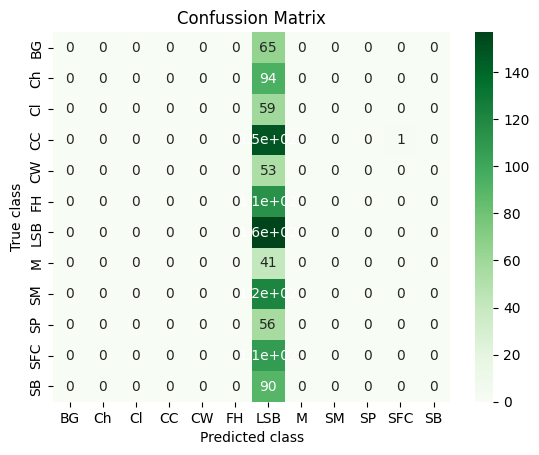

In [23]:
# these we will display in the below matrix
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

# plot consuffusion matrix
fig, ax = plt.subplots(1)
ax = sns.heatmap(conf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confussion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [24]:
accuracy_score(
    encoder.transform(y_test),
    preds,
    normalize=True,
    sample_weight=None
)
print(classification_report(encoder.transform(y_test), preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.00      0.00      0.00        94
           2       0.00      0.00      0.00        59
           3       0.00      0.00      0.00       150
           4       0.00      0.00      0.00        53
           5       0.00      0.00      0.00       114
           6       0.14      1.00      0.25       157
           7       0.00      0.00      0.00        41
           8       0.00      0.00      0.00       122
           9       0.00      0.00      0.00        56
          10       0.00      0.00      0.00       107
          11       0.00      0.00      0.00        90

    accuracy                           0.14      1108
   macro avg       0.01      0.08      0.02      1108
weighted avg       0.02      0.14      0.04      1108



/home/paperspace/miniconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paperspace/miniconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paperspace/miniconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo